In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ultranest
import ultranest.stepsampler as ultrastep
import pickle
import sys,os
sys.path.append('../../')
import project.profiles as pp

In [2]:
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))
mwd = MW_dict.copy()

In [3]:
mw_RC = MW_dict['RC']
mw_r, mw_v, mw_e = mw_RC[:,0], mw_RC[:,1], mw_RC[:,2]

def RCmodel(params,output = 'model',r = mw_r):
    m200,c200,mdstar,mdbul,mdgas,rdstar,rdbul,rdgas = params
    rs = pp.rs_nfw(np.log10(m200)+12., c200)
    vnfw = pp.v_nfw(np.log10(m200)+12., rs, r)
    vdstar = pp.v_exp(np.log10(mdstar)+9., rdstar, r)
    vdgas = pp.v_exp(np.log10(mdgas)+9., rdgas, r)
    vdbul = pp.v_exp(np.log10(mdbul)+9., rdbul, r)
    vmodel = np.sqrt(vnfw**2 + vdgas**2 + vdbul**2 + vdstar**2)
    if output == 'model':
        return vmodel
    elif output == 'all':
        return (vmodel, vnfw, vdstar, vdgas, vdbul)

In [4]:
param_names = list(MW_dict['fiducial_range'].keys())

ranges = [[0.1,5.0],[5.0,21.0],
          [10.0,100.0],[1.0,50.0],[1.0,50.0],
          [2.0,8.0],[0.2,2.0],[2.0, 25.0]]

def prior(cube):
    params = cube.copy()
    for i, key in enumerate(param_names):
        fid = ranges[i]
        params[i] = cube[i]*(fid[1] - fid[0]) + fid[0]
    return params

def llike(params):
    if params[7] < params[5]:
        return -1e38
    if params[6] > params[5]:
        return -1e38
    if (params[2] < params[3]) or (params[2] < params[4]):
        return -1e38
    vmodel = RCmodel(params)
    indx = np.where((mw_r >= 0))
    ll = -0.5*(((mw_v[indx] - vmodel[indx])/(mw_e[indx]))**2).sum()
    ll -= ((np.log10(params[1]) - pp.lc200_SR(np.log10(params[0])+12.0))/0.11)**2
    return ll

In [5]:
ultraroot = '../Output/Ultra/MW_RC_fit'
nsteps = 4*len(param_names)
sampler = ultranest.ReactiveNestedSampler(param_names, llike, prior,
                                          log_dir = ultraroot, 
                                          resume = 'resume')
sampler.stepsampler = ultrastep.RegionSliceSampler(nsteps = nsteps)

In [6]:
result = sampler.run()

[ultranest] Resuming from 14640 stored points
[ultranest] Widening roots to 546 live points (have 400 already) ...
[ultranest] Widening roots to 739 live points (have 546 already) ...


[ultranest] Explored until L=-8e+01  9 [-78.6583..-78.6572]*| it/evals=14208/895080 eff=inf% N=400    0   00  0 
[ultranest] Likelihood function evaluations: 895080
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -109.1 +- 0.1975
[ultranest] Effective samples strategy satisfied (ESS = 3541.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.15 to 0.61, need <0.5)
[ultranest]   logZ error budget: single: 0.26 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.


In [7]:
for i, key in enumerate(MW_dict['fiducial_range'].keys()):
    mean = result['posterior']['mean']
    fid = MW_dict['fiducial_range'][key]
    print (f'----{key}--------')
    print (f'[{fid[0]:.1f}, {mean[i]:.1f},  {fid[1]:.1f}]')

----m200--------
[0.9, 0.7,  1.6]
----c200--------
[9.0, 10.3,  17.0]
----mdstar--------
[42.0, 50.2,  63.0]
----mdbul--------
[8.0, 8.3,  20.0]
----mdgas--------
[1.0, 37.0,  20.0]
----rdstar--------
[2.0, 2.9,  4.0]
----rdbul--------
[1.9, 0.2,  2.0]
----rdgas--------
[5.0, 8.9,  20.0]


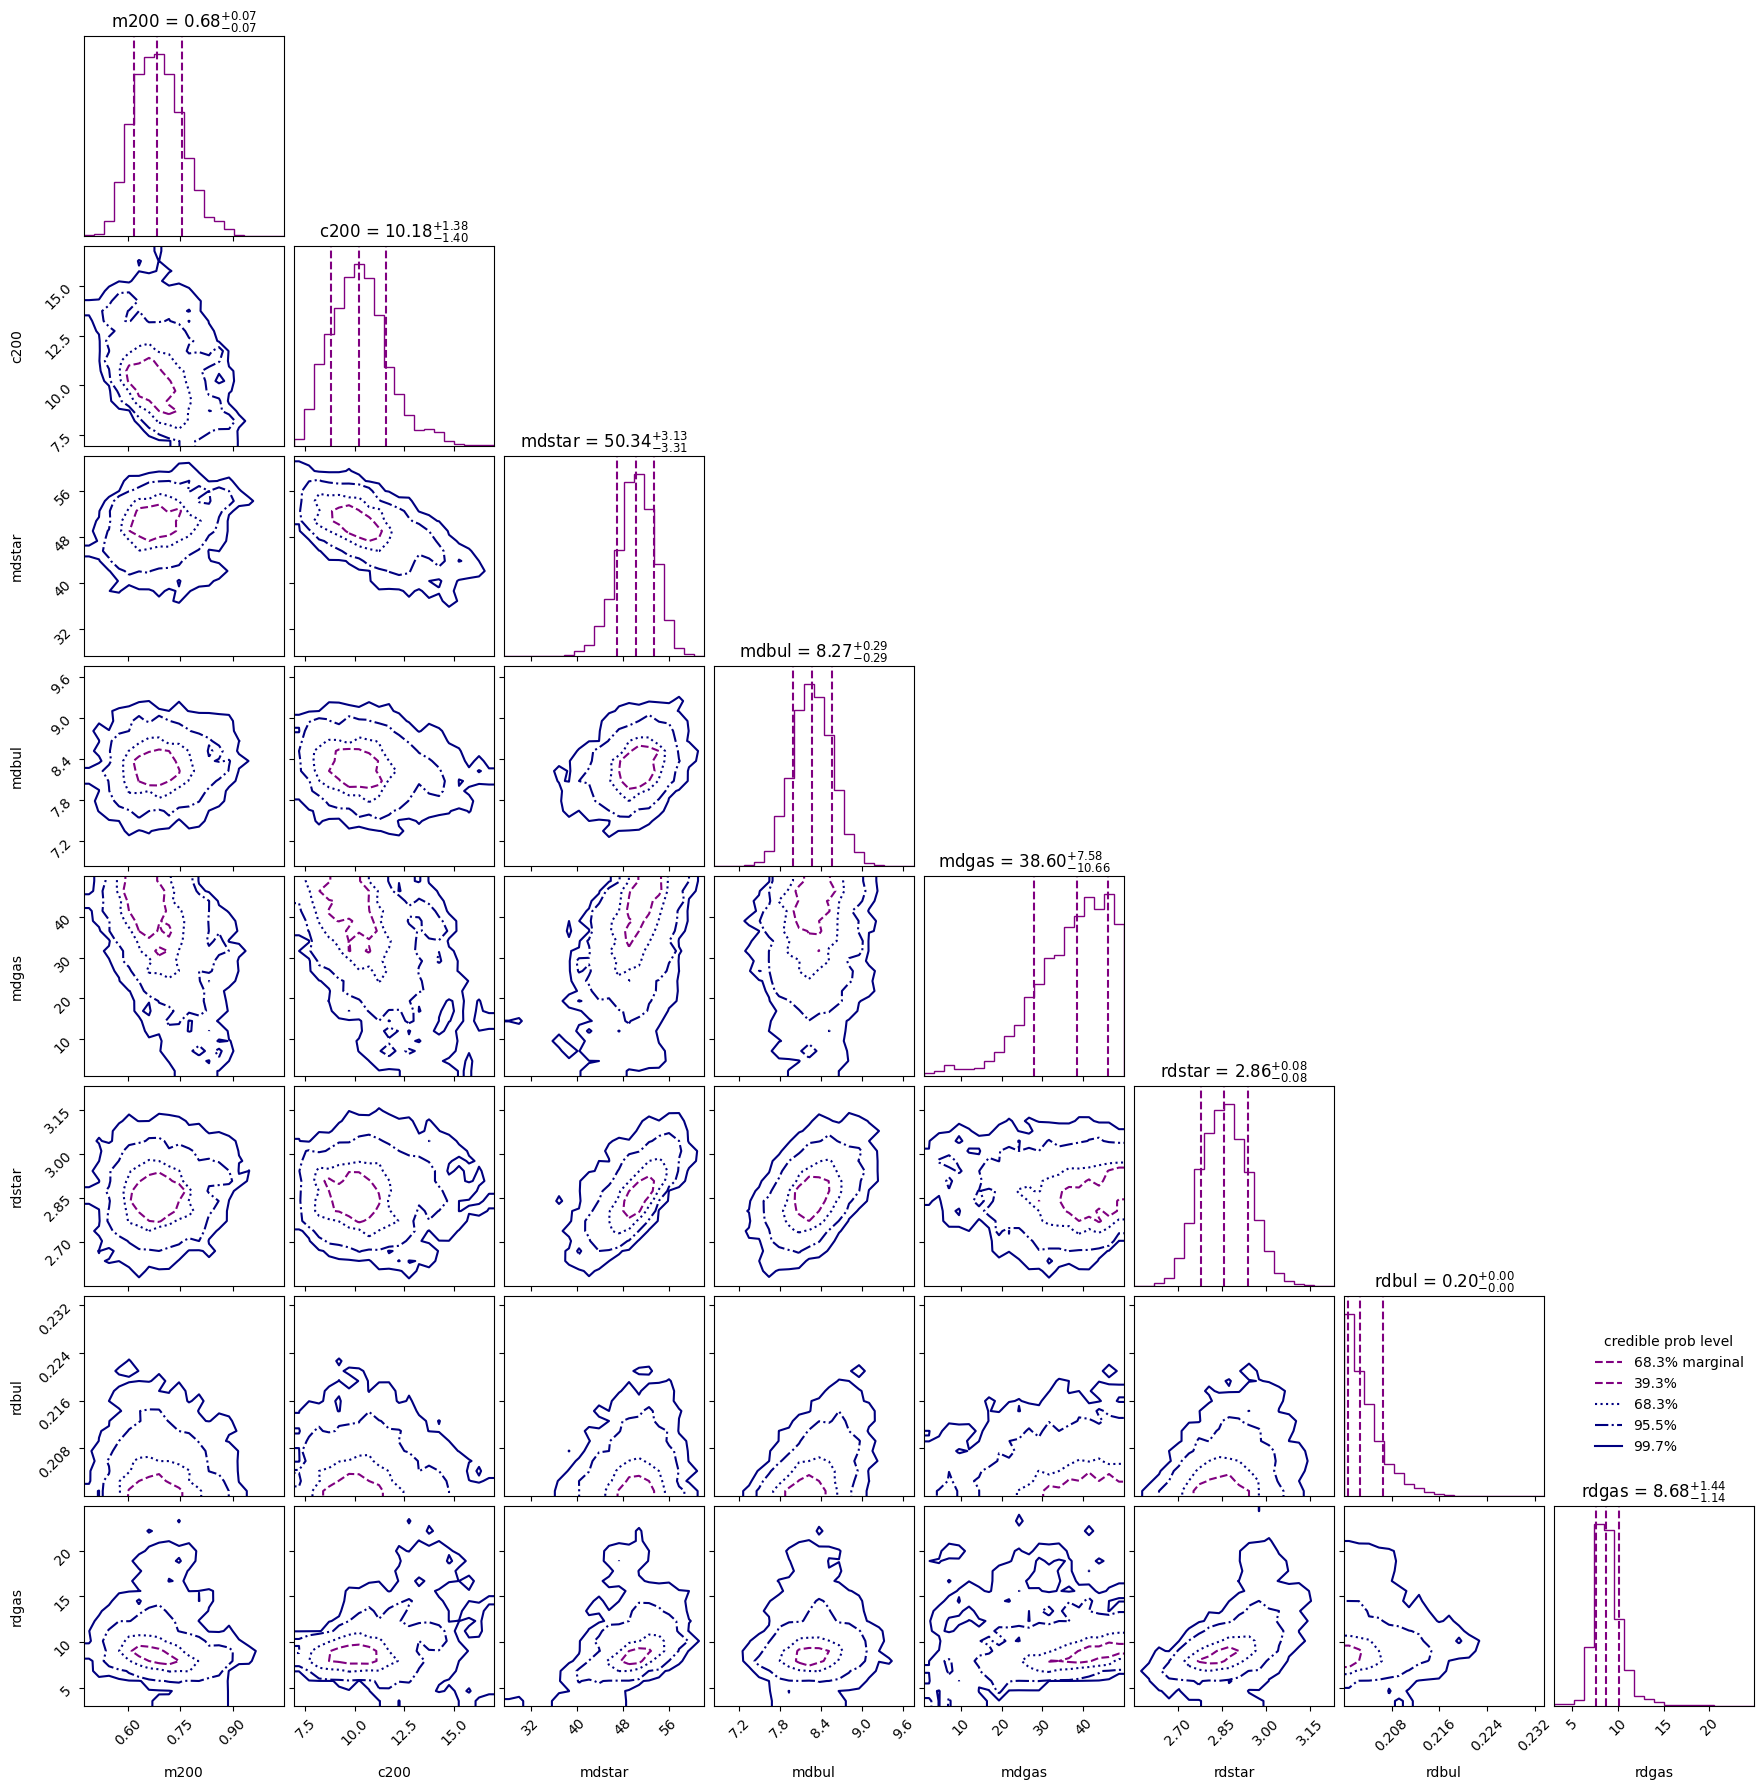

In [8]:
from ultranest.plot import cornerplot
cornerplot(result)
plt.savefig('../Output/figures/MWfit_corner.png',bbox_inches = 'tight',dpi = 300)

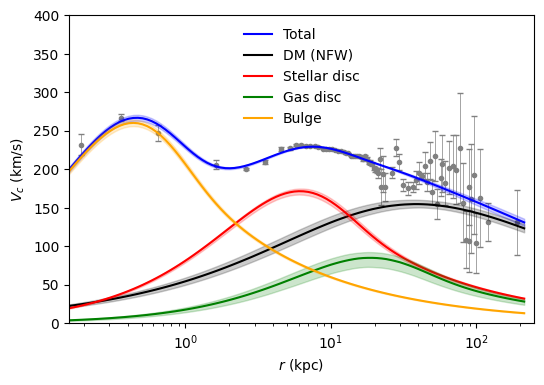

In [9]:
from ultranest.plot import PredictionBand

fig,ax = plt.subplots(figsize = (6,4))
ax.errorbar(mw_r, mw_v, mw_e, fmt = '.', elinewidth = 0.5, capsize = 2, alpha = 1, c = 'grey', zorder = 0)

names = ['Total', 'DM (NFW)', 'Stellar disc', 'Gas disc', 'Bulge']
clrs = ['b', 'k', 'r', 'g', 'orange']

R = np.logspace(-0.8,2.33,100)
bands = [PredictionBand(R) for name in names]

for params in sampler.results['samples']:
    vnames = RCmodel(params,'all',R)
    for i,band in enumerate(bands):
        band.add(vnames[i])

for i,band in enumerate(bands):
    band.line(color = clrs[i], zorder = 1, label = names[i])
    band.shade(color = clrs[i], alpha = 0.2, zorder = 1)

ax.legend(framealpha = 0)
ax.set_xscale('log')
ax.set_xlabel('$r$ (kpc)')
ax.set_ylabel('$V_c$ (km/s)')
ax.set_xlim(10**-0.8,250)
ax.set_ylim(0,400)

plt.savefig('../Output/figures/MWRC_fit.pdf',bbox_inches = 'tight',dpi = 300)